In [37]:
#|default_exp autometric
# Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import autometric
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# String Geodesics
> No Flows, no ODEs, no distributions: just a string in the wind.

# Implementation

In [58]:
#|export
import torch
from torch import nn
import lightning as pl

class StringGeodesic(pl.LightningModule):
    def __init__(self, 
                 metric, # a metric object.
                 start, # starting point
                 end, # ending point
                 dim: int = 2, # dimension of the space in which the metric lives.
                 num_beads: int = 1000,
                 flexibility: int = 10,
                 step_size = 1e-3,
                 ):
        super().__init__()
        
        self.dim = dim
        self.num_beads = num_beads
        self.metric = metric
        self.flexibility = flexibility
        self.step_size = step_size
        
        self.beads = torch.vstack(
            [torch.lerp(start, end, t) for t in torch.linspace(0,1,steps=num_beads)]
        ).float()
        self.metric_per_bead = self.metric.metric_matrix(self.beads).float()

        # Create the network layers
        self.Force = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, dim),
        )
    
    def progressive_lengths(self, beads, metric_per_bead):
        # Computes length between each consecutive bead
        lengths = torch.zeros(self.num_beads)
        for i in range(1, len(beads)):
            lengths[i]  = lengths[i-1] + torch.sqrt(self.metric.inner_product(beads[i] -  beads[i-1], beads[i] -  beads[i-1], matrix = metric_per_bead[i]))
        return lengths
    
    def apply_force(self, beads, forces, lengths):
        # applies the force given to each bead, modulating by lengths
        distances_from_end = torch.sqrt(lengths * (lengths[-1] - lengths)) 
        force_modulator = torch.sigmoid(self.flexibility*distances_from_end)*2 - 1
        fm = (self.step_size*force_modulator[:,None])
        beads_after_wind = fm*forces + beads
        return beads_after_wind
        
    def forward(self):
        # get distances at start
        self.metric_per_bead = self.metric.metric_matrix(self.beads).float()
        beginning_distances = self.progressive_lengths(self.beads, self.metric_per_bead)
        # calculate force assigned to each bead
        force = self.Force(self.beads)
        # apply the force to get new beads
        self.beads = self.apply_force(self.beads, force, beginning_distances)
        # compute new distances
        self.metric_per_bead = self.metric.metric_matrix(self.beads).float()
        end_distances = self.progressive_lengths(self.beads, self.metric_per_bead)
        return end_distances[-1]


# Testing

In [59]:
from autometric.datasets import Sphere

In [60]:
start = torch.tensor([0.1, 0.9])
end = torch.tensor([0.9, 0.1])

In [61]:
sphere = Sphere()
SG = StringGeodesic(
    sphere.metric,
    start = start,
    end = end,
    dim = 2,
    step_size = 1
)

In [62]:
beads_per_time = []
for t in trange(100):
    d = SG.forward()
    beads_per_time.append(SG.beads.detach().numpy())
beads_per_time = np.array(beads_per_time)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
from autometric.utils import gif_from_multiarray


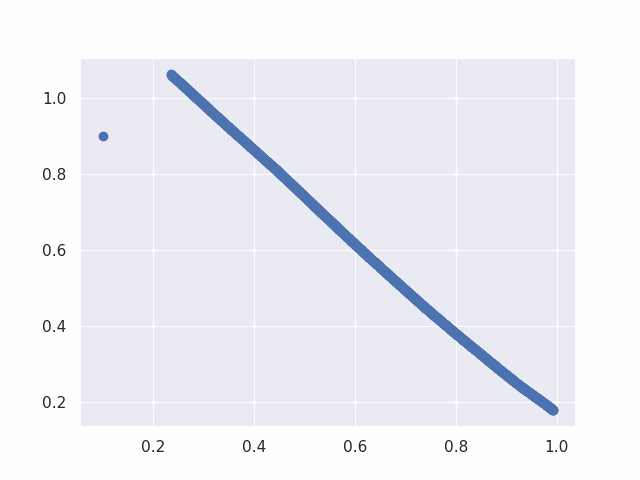

In [47]:
gif_from_multiarray(np.array(beads_per_time))

In [44]:
SG.Force(torch.rand(2))

tensor([ 0.0879, -0.1021], grad_fn=<ViewBackward0>)

In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync